In [60]:
# !pip install autoviz

<center><img src ="https://miro.medium.com/max/720/1*_igArwmR7Pj_Mu_KUGD1SQ.webp"></center>
<h1> <center> Spam or Ham? Using LSTM to Detect Spams </center> </h1>

In [61]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pandas as pd

# Layers
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense, Dropout

<h2>Loading Data</h2>

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IUB/spam.csv', encoding = 'latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [64]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']) # Removing empty columns 
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


<h2>Visualizing Data</h2>

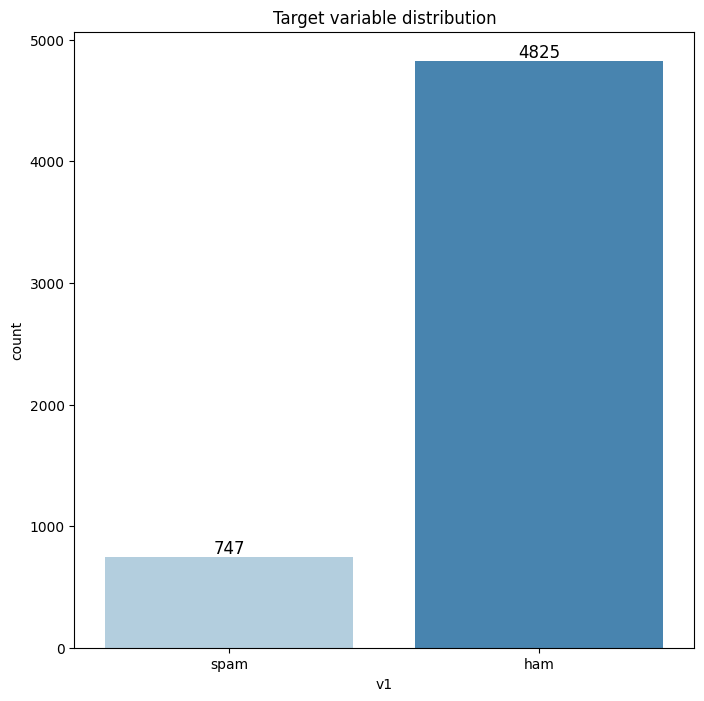

In [65]:
# Plotting a class distribution barplot
class_distribution = df['v1'].value_counts().sort_index(ascending = False)
plt.figure(figsize=(8,8))
ax = sns.countplot(x='v1', data=df, order = class_distribution.index, palette="Blues")
for i in ax.containers:
    ax.bar_label(i, label_type = 'edge', fontsize = 12)
plt.title('Target variable distribution')
plt.show()

In [68]:
# Printing examples of ham messages
print("Ham texts:")
print(df[df['v1'] == 'ham']['v2'].head())

Ham texts:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: v2, dtype: object


In [69]:
# Printing examples of Spam messages 
print("Spams:")
print(df[df['v1'] == 'spam']['v2'].head())

Spams:
2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: v2, dtype: object


<h2>Data Preprocessing</h2>

In [70]:
# Creating a function to clean text data
def text_cleaning(text):
    # Removing punctuation 
    text = re.sub(r'[^\w\s]', '', text)
    # Converting text to lowercase
    text = text.lower()
    # Removing digits
    text = re.sub(r'\d+','',text)
    # Removing stopwords that are common in the English language
    stop = stopwords.words('english')
    text = " ".join([word for word in text.split() if word not in stop])
    # Lemmatizing text
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    # Removing white spaces
    text = text.strip()
    
    return text

In [71]:
import nltk

In [72]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [74]:
# Splitting training and testing sets
X_train, X_test, y_train,y_test = train_test_split(df['v2'], df['v1'], test_size = 0.4, random_state = 123)

# Applying text_cleaning function
X_train = X_train.apply(text_cleaning)
X_test = X_test.apply(text_cleaning)

In [75]:
# Displaying text after cleansing 
X_train

73                               kkwhere youhow performed
2948                            bruce b down amp fletcher
1000                                  nobut heard abt tat
3993               love cuddle want hold strong arm right
4197    want funk ur fone weekly new tone reply tonesu...
                              ...                        
5218                     accidentally brought em home box
4060    aight ive set free think could text blake addr...
1346    ok stay night xavier sleeping bag im getting t...
3454    need lar jus testing e phone card dunno networ...
3582                         sent maga money yesterday oh
Name: v2, Length: 3343, dtype: object

In [76]:
# Data tokenization and padding 
max_lenght = max([len(i) for i in X_train])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_lenght)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_lenght)

In [77]:
# Fixing class imbalance with SMOTE
smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [78]:
# Counting values after SMOTE
y_train.value_counts()

ham     2884
spam    2884
Name: v1, dtype: int64

In [79]:
# Encoding target variable 
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

<h2>Creating a LSTM Model</h2>

In [86]:
from keras.utils.vis_utils import plot_model

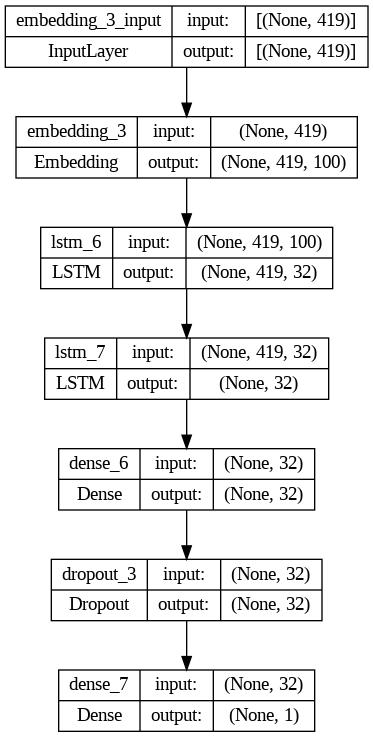

In [87]:
# Defining model structure
model = Sequential()
# Adding embedding layer to convert input data into a dense vector representation
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim = 100, input_length = max_lenght))
# Adding LSTM layers 
model.add(LSTM(units=32, return_sequences = True))
model.add(LSTM(units=32))
# Adding a Dense Layer
model.add(Dense(units=32, activation = 'relu'))
# Adding a Dropout layer, in order to prevent overfitting
model.add(Dropout(rate=0.2))
# Adding an output Dense layer
model.add(Dense(units=1, activation = 'sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [81]:
# Visualizing model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 419, 100)          596500    
                                                                 
 lstm_2 (LSTM)               (None, 419, 32)           17024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 622,933
Trainable params: 622,933
Non-tr

In [88]:
# Defining an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

In [89]:
# Compiling model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
# Fitting model
history = model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.3, callbacks =[early_stopping])

Epoch 1/10
127/127 [==============================] - 22s 144ms/step - loss: 0.3895 - accuracy: 0.8269 - val_loss: 0.6571 - val_accuracy: 0.7048
Epoch 2/10
127/127 [==============================] - 12s 92ms/step - loss: 0.1713 - accuracy: 0.9398 - val_loss: 0.5639 - val_accuracy: 0.7643
Epoch 3/10
127/127 [==============================] - 7s 56ms/step - loss: 0.0902 - accuracy: 0.9770 - val_loss: 1.0830 - val_accuracy: 0.6424
Epoch 4/10
127/127 [==============================] - 5s 42ms/step - loss: 0.0463 - accuracy: 0.9886 - val_loss: 0.9787 - val_accuracy: 0.7239
Epoch 5/10
127/127 [==============================] - 5s 38ms/step - loss: 0.0389 - accuracy: 0.9921 - val_loss: 1.4264 - val_accuracy: 0.6285
Epoch 6/10
127/127 [==============================] - 6s 44ms/step - loss: 0.0299 - accuracy: 0.9936 - val_loss: 1.5943 - val_accuracy: 0.6343
Epoch 7/10
127/127 [==============================] - 5s 38ms/step - loss: 0.0284 - accuracy: 0.9938 - val_loss: 1.5213 - val_accuracy: 0.6

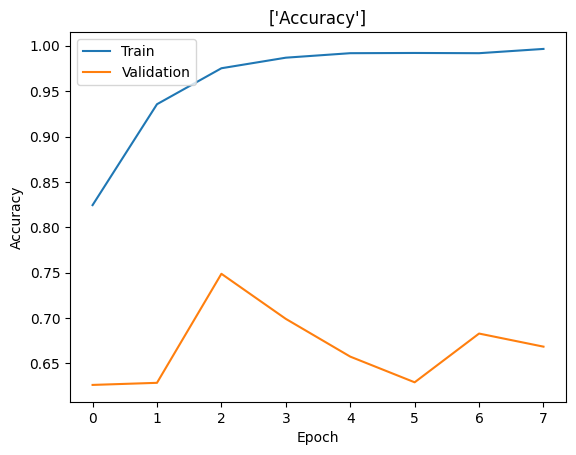

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(['Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

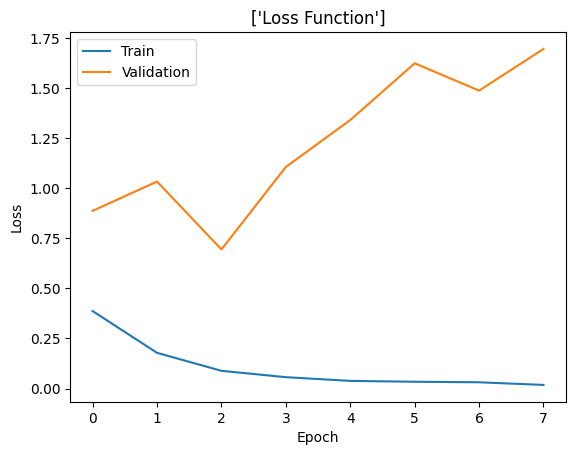

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(['Loss Function'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

In [56]:
# Running model on testing set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

70/70 [==============================] - 2s 12ms/step


In [92]:
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
# Creating classification report 
targetnames=['ham','spam']
report = classification_report(y_test, y_pred , target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.96      0.97      1941
        spam       0.78      0.93      0.85       288

    accuracy                           0.96      2229
   macro avg       0.88      0.95      0.91      2229
weighted avg       0.96      0.96      0.96      2229



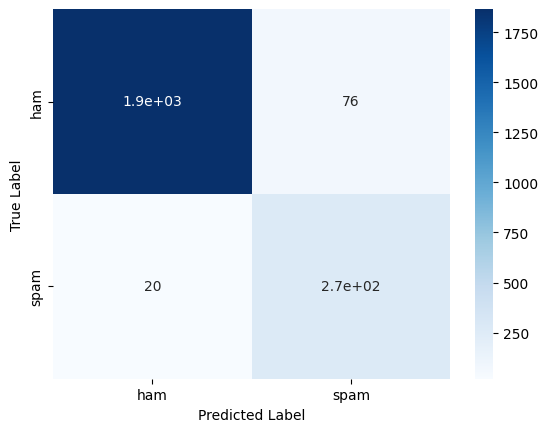

In [93]:

# Plotting a confusion matrix
cm = confusion_matrix(y_test, y_pred).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()